# Orthogonal Collocation


In [7]:
import numpy as np
from scipy.optimize import fsolve

x0 = np.array([-.5,0])
tf = 10
# z is vector of all unknowns
z_guess = np.zeros(12)

N = np.array([[0.436,-0.281, 0.121], \
              [0.614, 0.064, 0.0461], \
              [0.603, 0.230, 0.167]])

time = np.array([0.0,0.5-np.sqrt(5)/10.0, 0.5+np.sqrt(5)/10.0, 1.0]) * tf

def func(z):
    u = 0.5
    #extract out unknowns and put in useful forms
    x11,x12,x13,x21,x22,x23 = z[:6]
    dx11,dx12,dx13,dx21,dx22,dx23 = z[-6:]
    dx1 = np.array([dx11,dx12,dx13])
    dx2 = np.array([dx21,dx22,dx23])
    x1 = np.array([x11,x12,x13])
    x2 = np.array([x21,x22,x23])

    #residuals. order doesn't really matter like with ode... 
    F = np.zeros(12)
    F[0:3] = dx1 - u
    F[3] = dx21 - (x11**2 - u)
    F[4] = dx22 - (x12**2 - u)
    F[5] = dx23 - (x13**2 - u)
    F[6:9] = tf * N @ dx1 - (x1 -x0[0])
    F[-3:] =  tf * N @ dx2 - (x2 -x0[1])

    return F
    
sol = fsolve(func, z_guess)
print(f'x1 = {x0[0]},{sol[0]},{sol[1]},{sol[2]}')
print(f'x2 = {x0[1]},{sol[3]},{sol[4]},{sol[5]}')
print(f'dx1 = {sol[6]},{sol[7]},{sol[8]}')
print(f'dx2 = {sol[9]},{sol[10]},{sol[11]}')




x1 = -0.5,0.8799999999999998,3.1205,4.5
x2 = 0.0,-0.8635479025000041,16.70157895999997,55.88342857499992
dx1 = 0.5,0.5,0.5
dx2 = 0.27439999999999864,9.237520249999985,19.749999999999975


In [8]:
# Solution for Orthogonal Collocation on Finite Elements
import numpy as np
from gekko import GEKKO

tf = 10
u  = 0.5

x10 = -0.5
x20 =  0.0

m = GEKKO()
x11,x12,x13 = m.Array(m.Var,3)
x21,x22,x23 = m.Array(m.Var,3)
dx11,dx12,dx13 = m.Array(m.Var,3)
dx21,dx22,dx23 = m.Array(m.Var,3)

m.Equations([tf * (0.436*dx11 -0.281*dx12 +0.121*dx13) == x11 - x10, \
             tf * (0.614*dx11 +0.064*dx12 +0.046*dx13) == x12 - x10, \
             tf * (0.603*dx11 +0.230*dx12 +0.167*dx13) == x13 - x10, \
             tf * (0.436*dx21 -0.281*dx22 +0.121*dx23) == x21 - x20, \
             tf * (0.614*dx21 +0.064*dx22 +0.046*dx23) == x22 - x20, \
             tf * (0.603*dx21 +0.230*dx22 +0.167*dx23) == x23 - x20, \
             dx11 == u, \
             dx12 == u, \
             dx13 == u, \
             dx21 == x11**2-u, \
             dx22 == x12**2-u, \
             dx23 == x13**2-u])

m.solve(disp=False)

print('States with Orthogonal Collocation')
print('x1 = ', x10, x11.value[0], x12.value[0], x13.value[0])
print('x2 = ', x20, x21.value[0], x22.value[0], x23.value[0])
print(' ')
print('Derivatives with Orthogonal Collocation')
print('dx1/dt = ', dx11.value[0], dx12.value[0], dx13.value[0])
print('dx2/dt = ', dx21.value[0], dx22.value[0], dx23.value[0])

States with Orthogonal Collocation
x1 =  -0.5 0.88 3.12 4.5
x2 =  0.0 -0.85478 16.679832 55.876252
 
Derivatives with Orthogonal Collocation
dx1/dt =  0.5 0.5 0.5
dx2/dt =  0.2744 9.2344 19.75


# Dynamic Optimization Problem


$$
\begin{aligned}
&\min _{u} \frac{1}{2} \int_{0}^{t_{f}} x_{1}^{2}(t) d t \\
&\text { s.t. } \frac{d x_{1}(t)}{d t}=u(t)+x_{2}(t) \\
&\frac{d x_{2}(t)}{d t}=-u(t) \\
&x(0)=[0.5,0] \\
&x\left(t_{f}\right)=[0,0] \\
&t_{f}=1.5 \\
&-1 \leq u(t) \leq 1
\end{aligned}
$$

apm 10.32.114.116_gk_model26 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            5
   Intermediates:            0
   Connections  :            0
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           3300
 Number of total equations: -         3600
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :           -300
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

Text(0.5, 0, 'Time')

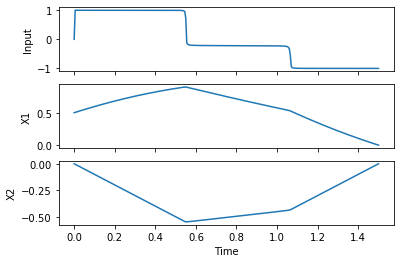

In [34]:
import matplotlib.pyplot as plt
m = GEKKO()

tf = 1.5
m.time = np.linspace(0,tf,301)

x1 = m.SV(.5)
x2 = m.SV(0)
u = m.MV(0,-1,1)
u.STATUS = 1 #let optimizer adjust

mask = np.zeros(301)
mask[-1] = 1
final = m.Param(value=mask)

m.Equation(x1.dt() == u + x2)
m.Equation(x2.dt() == -u)
m.Equation(x2*final == 0)
m.Equation(x1*final == 0)

m.Minimize(0.5 * m.integral(x1**2) * final)
m.options.IMODE = 6 
m.solve(disp=True)

fig,ax = plt.subplots(3,1,sharex=True)
ax[0].plot(m.time, u)
ax[0].set_ylabel('Input')
ax[1].plot(m.time, x1)
ax[1].set_ylabel('X1')
ax[2].plot(m.time, x2)
ax[2].set_ylabel('X2')
ax[2].set_xlabel('Time')





So not sure, but objective value depends on how tightly I discretize the system. It goes up as the discretization get finer, which is what I expect. But 1001 points is probably pretty close to the actual integral. 

apm 10.32.114.116_gk_model29 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            6
   Intermediates:            0
   Connections  :            0
   Equations    :            6
   Residuals    :            6
 
 Number of state variables:           2000
 Number of total equations: -         2100
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :           -100
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This

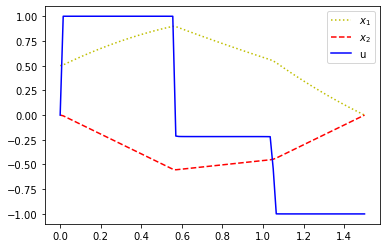

In [37]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

#Build Model ############################
m = GEKKO()

#define time space
nt = 101
m.time = np.linspace(0,1.5,nt)

#Parameters
u = m.MV(value =0, lb = -1, ub = 1)
u.STATUS = 1
# u.DCOST = 0.0001  # slight penalty to discourage MV movement

#Variables
x1 = m.Var(value=0.5)
x2 = m.Var(value =  0)
myObj = m.Var()

#Equations
# m.Equation(myObj.dt() == 0.5*x1**2)
m.Equation(x1.dt() == u + x2)
m.Equation(x2.dt() == -u)

f = np.zeros(nt)
f[-1] = 1
final = m.Param(value=f)

# Four options for final constraints x1(tf)=0 and x2(tf)=0
option = 1 # best option = 3 (fix endpoints directly)
if option == 1:
    # most likely to cause DOF issues because of many 0==0 equations
    m.Equation(final*x1 == 0)
    m.Equation(final*x2 == 0)
elif option == 2:
    # inequality constraint approach is better but there are still
    #   many inactive equations not at the endpoint
    m.Equation((final*x1)**2 <= 0)
    m.Equation((final*x2)**2 <= 0)
elif option == 3: #requires GEKKO version >= 0.0.3a2
    # fix the value just at the endpoint (best option)
    m.fix(x1,pos=nt-1,val=0)
    m.fix(x2,pos=nt-1,val=0)
else:
    #penalty method ("soft constraint") that may influence the
    # optimal solution because there is just one combined objective
    # and it may interfere with minimizing myObj
    m.Obj(1000*(final*x1)**2)
    m.Obj(1000*(final*x2)**2)

# m.Obj(myObj*final)

#soo... why does doing things with M.Obj cause DOF issues but then m.Minimize is just fine?

m.Minimize(0.5 * m.integral(x1**2)*final)

########################################
#Set Global Options and Solve
m.options.IMODE = 6
m.options.NODES = 3
m.options.MV_TYPE = 1
m.options.SOLVER = 3  # APOPT solver

#Solve
m.solve() # (remote=False) for local solution

########################################
#Plot Results
plt.figure()
plt.plot(m.time, x1.value, 'y:', label = '$x_1$')
plt.plot(m.time, x2.value, 'r--', label = '$x_2$')
plt.plot(m.time, u.value, 'b-', label = 'u')
plt.legend()
plt.show()

# Dynamic Estimation and Optimization Problem

 ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           61
   Intermediates:            1
   Connections  :            0
   Equations    :            5
   Residuals    :            4
 
 Number of state variables:           1743
 Number of total equations: -         1716
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             27
 
 ----------------------------------------------
 Dynamic Estimation with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0  3.30797E+08  5.00000E+01
    1  2.55573E+06  9.18780E-01
    2  6.02757E+05  5.10000E+01
    3  4.79651E+05  5.55706E-02
    4  3.61434

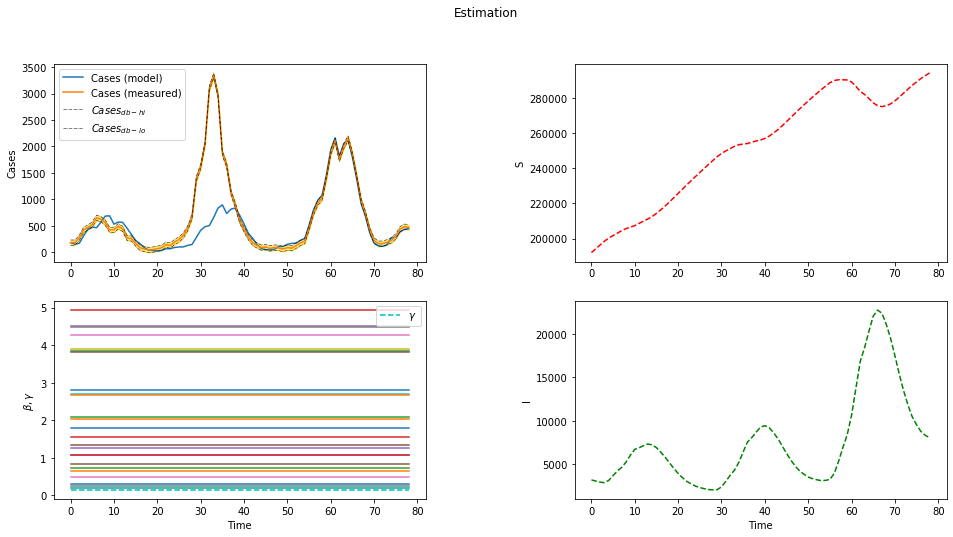

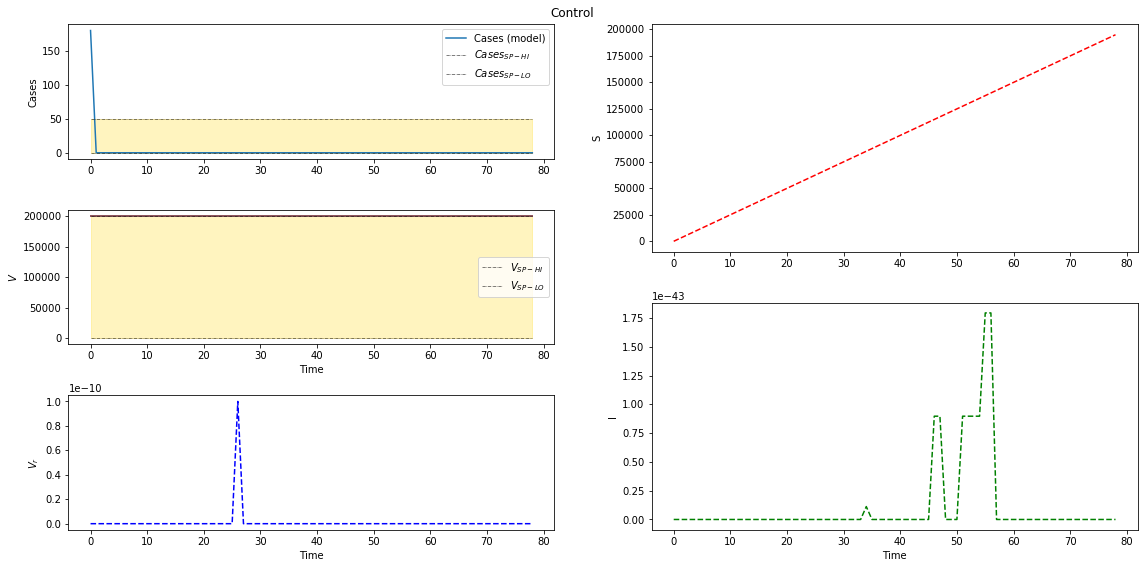

In [38]:
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt

m1 = GEKKO(remote=False)
m2 = GEKKO(remote=False)

m = m1
# known parameters
# number of biweeks in a year
nb = 26
ny = 3 # number of years

biweeks = np.zeros((nb,ny*nb+1))
biweeks[0][0] = 1
for i in range(nb):
   for j in range(ny):
      biweeks[i][j*nb+i+1] = 1

# write csv data file
tm = np.linspace(0,78,79)
# case data
cases = np.array([180,180,271,423,465,523,649,624,556,420,\
                  423,488,441,268,260,163,83,60,41,48,65,82,\
                  145,122,194,237,318,450,671,1387,1617,2058,\
                  3099,3340,2965,1873,1641,1122,884,591,427,282,\
                  174,127,84,97,68,88,79,58,85,75,121,174,209,458,\
                  742,929,1027,1411,1885,2110,1764,2001,2154,1843,\
                  1427,970,726,416,218,160,160,188,224,298,436,482,468])
data = np.vstack((tm,cases))
data = data.T
np.savetxt('measles_biweek_2.csv',data,delimiter=',',header='time,cases')

#load data from csv
m.time, cases_meas = np.loadtxt('measles_biweek_2.csv', \
                delimiter=',',skiprows=1,unpack=True)

m.Vr = m.Param(value = 0)
# Variables
m.N = m.FV(value = 3.2e6)
m.mu = m.FV(value = 7.8e-4)

m.rep_frac = m.FV(value = 0.45)
# beta values (unknown parameters in the model)
m.beta = [m.FV(value=1, lb=0.1, ub=5) for i in range(nb)]
# predicted values
m.S = m.SV(value = 0.06*m.N.value, lb=0,ub=m.N)
m.I = m.SV(value = 0.001*m.N.value, lb=0,ub=m.N)

m.V = m.Var(value = 2e5)

# measured values
m.cases = m.CV(value = cases_meas, lb=0)
# turn on feedback status for CASES
m.cases.FSTATUS = 1
# weight on prior model predictions
m.cases.WMODEL = 0
# meas_gap = deadband that represents level of
#   accuracy / measurement noise
db = 100
m.cases.MEAS_GAP = db

for i in range(nb):
   m.beta[i].STATUS=1

m.gamma = m.FV(value=0.07)
m.gamma.STATUS = 1
m.gamma.LOWER = 0.05
m.gamma.UPPER = 0.5

m.biweek=[None]*nb
for i in range(nb):
   m.biweek[i] = m.Param(value=biweeks[i])

# Intermediate
m.Rs = m.Intermediate(m.S*m.I/m.N)

# Equations
sum_biweek = sum([m.biweek[i]*m.beta[i]*m.Rs for i in range(nb)])
m.Equation(m.S.dt()== -sum_biweek + m.mu*m.N - m.Vr)
m.Equation(m.I.dt()== sum_biweek - m.gamma*m.I)
m.Equation(m.cases == m.rep_frac*sum_biweek)
m.Equation(m.V.dt()==-m.Vr)

# options
m.options.SOLVER = 1
m.options.NODES=3
# imode = 5, dynamic estimation
m.options.IMODE = 5
# ev_type = 1 (L1-norm) or 2 (squared error)
m.options.EV_TYPE = 1

# solve model and print solver output
m.solve()

[print('beta['+str(i+1)+'] = '+str(m.beta[i][0])) \
 for i in range(nb)]
print('gamma = '+str(m.gamma.value[0]))

# export data
# stack time and avg as column vectors
my_data = np.vstack((m.time,np.asarray(m.beta),m.gamma))
# transpose data
my_data = my_data.T
# save text file with comma delimiter
beta_str = ''
for i in range(nb):
   beta_str = beta_str + ',beta[' + str(i+1) + ']'
header_name = 'time,gamma' + beta_str
##np.savetxt('solution_data.csv',my_data,delimiter=',',\
##           header = header_name, comments='')
np.savetxt('solution_data_EVTYPE_'+str(m.options.EV_TYPE)+\
           '_gamma'+str(m.gamma.STATUS)+'.csv',\
           my_data,delimiter=',',header = header_name)

plt.figure(num=1, figsize=(16,8))
plt.suptitle('Estimation')
plt.subplot(2,2,1)
plt.plot(m.time,m.cases, label='Cases (model)')
plt.plot(m.time,cases_meas, label='Cases (measured)')
if m.options.EV_TYPE==1:
   plt.plot(m.time,cases_meas+db/2, 'k-.',\
            lw=0.5, label=r'$Cases_{db-hi}$')
   plt.plot(m.time,cases_meas-db/2, 'k-.',\
            lw=0.5, label=r'$Cases_{db-lo}$')
   plt.fill_between(m.time,cases_meas-db/2,\
                    cases_meas+db/2,color='gold',alpha=.5)
plt.legend(loc='best')
plt.ylabel('Cases')
plt.subplot(2,2,2)
plt.plot(m.time,m.S,'r--')
plt.ylabel('S')
plt.subplot(2,2,3)
[plt.plot(m.time,m.beta[i], label='_nolegend_')\
 for i in range(nb)]
plt.plot(m.time,m.gamma,'c--', label=r'$\gamma$')
plt.legend(loc='best')
plt.ylabel(r'$\beta, \gamma$')
plt.xlabel('Time')
plt.subplot(2,2,4)
plt.plot(m.time,m.I,'g--')
plt.xlabel('Time')
plt.ylabel('I')
plt.subplots_adjust(hspace=0.2,wspace=0.4)

name = 'cases_EVTYPE_'+ str(m.options.EV_TYPE) +\
       '_gamma' + str(m.gamma.STATUS) +  '.png'
plt.savefig(name)

##-----------------------------------------------##
## Control
##-----------------------------------------------##

m = m2

m.time = m1.time

# Variables
N = m.FV(value = 3.2e6)
mu = m.FV(value = 7.8e-4)

rep_frac = m.FV(value = 0.45)
# beta values (unknown parameters in the model)
beta = [m.FV(value = m1.beta[i].NEWVAL) for i in range(nb)]
gamma = m.FV(value = m1.gamma.NEWVAL)

cases = m.CV(value = cases_meas[0],lb=0)

# predicted values
S = m.SV(value=0.06*N, lb=0,ub=N)
I = m.SV(value = 0.001*N, lb=0,ub=N)

V = m.CV(value = 2e5)
Vr = m.MV(value = 0)

cases.STATUS = 1
cases.FSTATUS = 0
cases.TR_INIT = 0
cases.SPHI = 50
cases.SPLO = 0
cases_SPHI = np.full(len(m.time),cases.SPHI)
cases_SPLO = np.full(len(m.time),cases.SPLO)

Vr.STATUS = 1
Vr.UPPER = 1e4
Vr.LOWER = 0
Vr.COST = 1e-5

V.SPHI = 2e5
V.SPLO = 0
V.STATUS = 0
V.TR_INIT = 0
V_SPHI = np.full(len(m.time),V.SPHI)
V_SPLO = np.full(len(m.time),V.SPLO)

biweek=[None]*nb
for i in range(nb):
   biweek[i] = m.Param(value=biweeks[i])

# Intermediates
Rs = m.Intermediate(S*I/N)

#Equations
sum_biweek = sum([biweek[i]*beta[i]*Rs for i in range(nb)])
m.Equation(S.dt()== -sum_biweek + mu*N - Vr)
m.Equation(I.dt()== sum_biweek - gamma*I)
m.Equation(cases == rep_frac*sum_biweek)
m.Equation(V.dt() == -Vr)

# options
m.options.SOLVER = 1
# imode = 6, dynamic control
m.options.IMODE = 6
# ctrl_units = 5, time units are in years
m.options.CTRL_UNITS = 5
m.options.CV_TYPE = 1

# solve model and print solver output
m.solve()

[print('beta['+str(i+1)+'] = '+str(beta[i][0]))\
 for i in range(nb)]
print('gamma = '+str(gamma.value[0]))

# export data
# stack time and avg as column vectors
my_data = np.vstack((m.time,np.asarray(beta),V,Vr,gamma))
# transpose data
my_data = my_data.T
# save text file with comma delimiter
beta_str = ''
for i in range(nb):
   beta_str = beta_str + ',beta[' + str(i+1) + ']'
header_name = 'time,gamma' + beta_str
##np.savetxt('solution_data.csv',my_data,delimiter=',',\
##           header = header_name, comments='')
np.savetxt('solution_control_EVTYPE_'+str(m.options.EV_TYPE)+\
           '_gamma'+str(gamma.STATUS)+'.csv',\
           my_data,delimiter=',',header = header_name)

plt.figure(num=2, figsize=(16,8))
plt.suptitle('Control')
plt.subplot2grid((6,2),(0,0), rowspan=2)
plt.plot(m.time,cases, label='Cases (model)')
plt.plot(m.time,cases_SPHI, 'k-.', lw=0.5,\
         label=r'$Cases _{SP-HI}$')
plt.plot(m.time,cases_SPLO, 'k-.', lw=0.5,\
         label=r'$Cases _{SP-LO}$')
plt.fill_between(m.time,cases_SPLO,cases_SPHI,\
                 color='gold',alpha=.25)
plt.legend(loc='best')
plt.ylabel('Cases')

plt.subplot2grid((6,2),(0,1), rowspan=3)
plt.plot(m.time,S,'r--')
plt.ylabel('S')

plt.subplot2grid((6,2),(2,0), rowspan=2)
[plt.plot(m.time,V, label='_nolegend_') for i in range(nb)]
plt.plot(m.time,V_SPHI, 'k-.', lw=0.5,\
         label=r'$V _{SP-HI}$')
plt.plot(m.time,V_SPLO, 'k-.', lw=0.5,\
         label=r'$V _{SP-LO}$')
plt.fill_between(m.time,V_SPLO,V_SPHI,color='gold',alpha=.25)
plt.legend(loc='best')
plt.ylabel(r'$V$')
plt.xlabel('Time')

plt.subplot2grid((6,2),(3,1),rowspan=3)
plt.plot(m.time,I,'g--')
plt.xlabel('Time')
plt.ylabel('I')

plt.subplot2grid((6,2),(4,0),rowspan=2)
plt.plot(m.time,Vr, 'b--')
plt.ylabel(r'$V_{r}$')
plt.xlabel('Time')
plt.tight_layout()
plt.subplots_adjust(top=0.95,wspace=0.2)
name = 'cases_EVTYPE_'+ str(m.options.EV_TYPE) + '_gamma'+\
       str(gamma.STATUS) +  '.png'
plt.savefig(name)

plt.show()